# Quick example of pack and train using linear regression


In [1]:
import intake
import time
import os

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
from cartopy import crs as ccrs
from fv3fit._shared.packer import ArrayPacker
from fv3viz import pcolormesh_cube, plot_cube_axes, mappable_var

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


/home/jmnugent/miniconda3/envs/fv3net/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


### Set file paths & look at available variables

In [2]:
DATA_PATH = '/mnt/disks/scratch/emulation_data/'
TRAIN_PATH = os.path.join(DATA_PATH, 'training/training-subsets/')
VALID_PATH = os.path.join(DATA_PATH, 'testing/validation-subsets/')

TRAIN_HYBRID = os.path.join(TRAIN_PATH, 'training-online-simple-hybedmf/')
VALID_HYBRID = os.path.join(VALID_PATH, 'training-online-simple-hybedmf/')

TRAIN_SIMPLE = os.path.join(TRAIN_PATH, 'simple-phys-hybridedmf-10day/')
VALID_SIMPLE = os.path.join(VALID_PATH, 'simple-phys-hybridedmf-10day/')

SAVE_DIR = '/home/jmnugent/fv3net/workflows/emulation/dataset_exploration/plots/'


In [3]:
train_list_simp = [TRAIN_SIMPLE + f for f in os.listdir(TRAIN_SIMPLE) if f.endswith('.nc')]
test_list_simp = [VALID_SIMPLE + f for f in os.listdir(VALID_SIMPLE) if f.endswith('.nc')]

print('simple physics =', len(train_list_simp), 'files, test =', len(test_list_simp), 'files')


simple physics = 432 files, test = 144 files


In [4]:
# quick look at all of the available data variables

print(TRAIN_SIMPLE, ':\n')
print([v for v in xr.open_dataset(train_list_simp[0]).data_vars])
print('\n\n', TRAIN_SIMPLE, ':\n')
print([v for v in xr.open_dataset(train_list_simp[0]).data_vars])


/mnt/disks/scratch/emulation_data/training/training-subsets/simple-phys-hybridedmf-10day/ :

['cos_day', 'sin_day', 'cos_month', 'sin_month', 'latitude', 'longitude', 'cos_lon', 'sin_lon', 'cos_zenith_angle', 'surface_pressure', 'surface_temperature', 'canopy_water', 'sea_ice_thickness', 'snow_depth_water_equivalent', 'vertical_thickness_of_atmospheric_layer', 'pressure_thickness_of_atmospheric_layer', 'eastward_wind', 'northward_wind', 'vertical_wind', 'air_temperature', 'specific_humidity', 'cloud_water_mixing_ratio', 'tendency_of_air_temperature_due_to_fv3_physics', 'tendency_of_specific_humidity_due_to_fv3_physics', 'tendency_of_eastward_wind_due_to_fv3_physics', 'tendency_of_northward_wind_due_to_fv3_physics', 'tendency_of_cloud_water_mixing_ratio_due_to_fv3_physics', 'total_soil_moisture', 'liquid_soil_moisture', 'soil_temperature']


 /mnt/disks/scratch/emulation_data/training/training-subsets/simple-phys-hybridedmf-10day/ :

['cos_day', 'sin_day', 'cos_month', 'sin_month', 'lat

### Read in the datasets
Only the input/output variables you want for now... but can probably change that once you fix the memory issues

In [5]:
qc = 'cloud_water_mixing_ratio'
dqcdt = 'tendency_of_cloud_water_mixing_ratio_due_to_fv3_physics'
tair = 'air_temperature'
pres = 'pressure_thickness_of_atmospheric_layer'
qv = 'specific_humidity'
tsfc = 'surface_temperature'

input_variables = [qc, tair, qv]
output_variables = [dqcdt]


In [6]:
%%time
# takes ~3.5 min

timesteps_train = [[]]*len(train_list_simp)
timesteps_test = [[]]*len(test_list_simp)

for i in range(len(train_list_simp)):
    timesteps_train[i] = xr.open_dataset(train_list_simp[i])[input_variables + output_variables]
    if i < len(test_list_simp):
        timesteps_test[i] = xr.open_dataset(test_list_simp[i])[input_variables + output_variables]


CPU times: user 13.4 s, sys: 1.24 s, total: 14.7 s
Wall time: 3min 27s


#### Combine along the sample dimension to merge the individual datasets into one

In [7]:
%%time

ds_train = xr.concat(timesteps_train, dim='sample')
ds_test = xr.concat(timesteps_test, dim='sample')


CPU times: user 58.3 s, sys: 8.72 s, total: 1min 6s
Wall time: 4min 19s


In [21]:
ds_train

<xarray.Dataset>
Dimensions:                                                  (sample: 1105920, z: 79)
Coordinates:
    time                                                     (sample) object ...
    x                                                        (sample) float64 ...
    tile                                                     (sample) int64 1...
    y                                                        (sample) float64 ...
Dimensions without coordinates: sample, z
Data variables:
    cloud_water_mixing_ratio                                 (sample, z) float64 ...
    air_temperature                                          (sample, z) float64 ...
    specific_humidity                                        (sample, z) float64 ...
    tendency_of_cloud_water_mixing_ratio_due_to_fv3_physics  (sample, z) float64 ...

### Get into numpy arrays using `ArrayPacker` and drop nans

In [8]:
stacked_train = ds_train.dropna(dim='sample')
stacked_test = ds_test.dropna(dim='sample')


In [9]:
# normalize the outputs
y_normalization = stacked_train[output_variables].std(dim="sample")

# use the ArrrayPacker class to convert into numpy arrays
X_packer = ArrayPacker(sample_dim_name="sample", pack_names=input_variables)
y_packer = ArrayPacker(sample_dim_name="sample", pack_names=output_variables)


In [10]:
# the packer needs to convert from dataset to array first:

X_train = X_packer.to_array(stacked_train)
y_train = y_packer.to_array(stacked_train)

X_test = X_packer.to_array(stacked_test)
y_test = y_packer.to_array(stacked_test)


In [11]:
# check shape... should be (# samples) x (total dimension of features)

X_train.shape, y_train.shape


((1105920, 237), (1105920, 79))

In [12]:
# use StandardScaler object to normalize the y target vector
# (y-mean)/std --> contributions of different vertical levels are
# equally weighted in the loss function

# ---> get a "not fitted error" later on in rf.fit without the .fit() call here
y_scaler = StandardScaler().fit(y_train)

# try this?
X_scaler = StandardScaler().fit(X_train)


#### Example of model training & prediction
Using default model config from `sklearn.ensemble.RandomForestRegressor`

Fit on *normalized* y data and inverse transform the initial RF prediction


In [13]:
# set normalize to false here because we used the standard scaler above

lr = LinearRegression(fit_intercept=True, normalize=False, n_jobs=-1)


In [14]:
%%time
# (with scaler on both X and y): takes 1 min (note: mem goes up to ~80%, but then down to <50% when done)

# lr.fit(X_train, y_scaler.transform(y_train))
lr.fit(X_scaler.transform(X_train), y_scaler.transform(y_train))


CPU times: user 1min 19s, sys: 14 s, total: 1min 33s
Wall time: 21.7 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [15]:
# y_predict = y_scaler.inverse_transform(lr.predict(X_test))
y_predict = y_scaler.inverse_transform(lr.predict(X_scaler.transform(X_test)))

ds_predict = y_packer.to_dataset(y_predict).assign_coords({"sample": stacked_test.sample})


#### Get the predicted mixing ratio

In [16]:
dt = 900 # seconds (= 15 min)

# testing
ds_qc_predict_vals = ds_test[qc] + ds_predict[dqcdt]*dt
ds_qc_predict = xr.Dataset(data_vars={qc: ds_qc_predict_vals}, coords=ds_test[qc].coords, attrs=ds_test[qc].attrs)

ds_qc_vals = ds_test[qc] + ds_test[dqcdt]*dt
ds_qc = xr.Dataset(data_vars={qc: ds_qc_vals}, coords=ds_test[qc].coords, attrs=ds_test[qc].attrs)


### Evaluate


##### Tendency

In [17]:
mae_avg = metrics.mean_absolute_error(y_test, y_predict, multioutput='uniform_average')
mae_z = metrics.mean_absolute_error(y_test, y_predict, multioutput='raw_values')

rmse_avg = np.sqrt(metrics.mean_squared_error(y_test, y_predict, multioutput='uniform_average'))
rmse_z = np.sqrt(metrics.mean_squared_error(y_test, y_predict, multioutput='raw_values'))

r2_avg = metrics.r2_score(y_test, y_predict, multioutput='uniform_average')
r2_z = metrics.r2_score(y_test, y_predict, multioutput='raw_values')


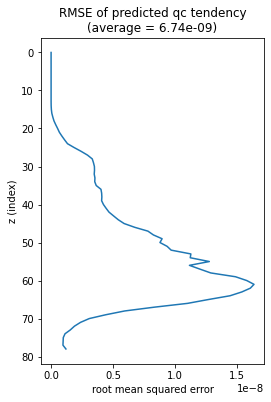

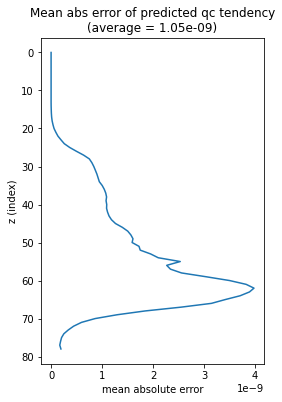

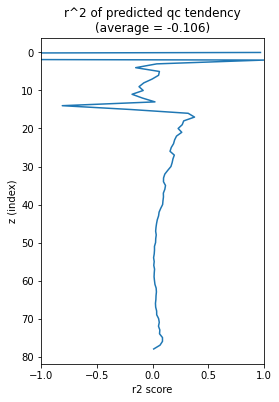

In [18]:
fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(rmse_z, np.arange(0, len(rmse_z)))
ax.set_ylabel('z (index)')
ax.set_xlabel('root mean squared error')
ax.set_title('RMSE of predicted qc tendency\n(average = {:.2e})'.format(rmse_avg))
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(mae_z, np.arange(0, len(mae_z)))
ax.set_ylabel('z (index)')
ax.set_xlabel('mean absolute error')
ax.set_title('Mean abs error of predicted qc tendency\n(average = {:.2e})'.format(mae_avg))
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(r2_z[:], np.arange(0, len(r2_z[:])))
ax.set_ylabel('z (index)')
ax.set_xlabel('r2 score')
ax.set_title('r^2 of predicted qc tendency\n(average = {:.3f})'.format(r2_avg))
ax.set_xlim((-1, 1))
ax.invert_yaxis()
plt.show()


##### Mixing ratio

In [19]:
mae_avg_qc = metrics.mean_absolute_error(ds_qc[qc], ds_qc_predict[qc], multioutput='uniform_average')
mae_z_qc = metrics.mean_absolute_error(ds_qc[qc], ds_qc_predict[qc], multioutput='raw_values')

rmse_avg_qc = np.sqrt(metrics.mean_squared_error(ds_qc[qc], ds_qc_predict[qc], multioutput='uniform_average'))
rmse_z_qc = np.sqrt(metrics.mean_squared_error(ds_qc[qc], ds_qc_predict[qc], multioutput='raw_values'))

r2_avg_qc = metrics.r2_score(ds_qc[qc], ds_qc_predict[qc], multioutput='uniform_average')
r2_z_qc = metrics.r2_score(ds_qc[qc], ds_qc_predict[qc], multioutput='raw_values')


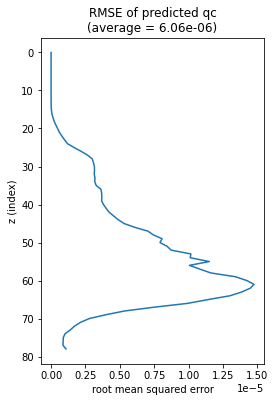

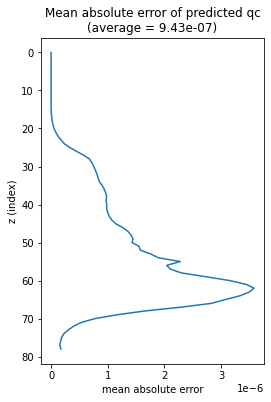

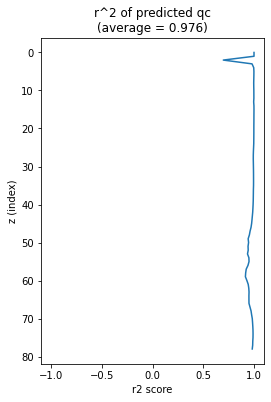

In [20]:
fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(rmse_z_qc, np.arange(0, len(rmse_z_qc)))
ax.set_ylabel('z (index)')
ax.set_xlabel('root mean squared error')
ax.set_title('RMSE of predicted qc\n(average = {:.2e})'.format(rmse_avg_qc))
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(mae_z_qc, np.arange(0, len(mae_z_qc)))
ax.set_xlabel('mean absolute error')
ax.set_ylabel('z (index)')
ax.set_title('Mean absolute error of predicted qc\n(average = {:.2e})'.format(mae_avg_qc))
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(r2_z_qc, np.arange(0, len(r2_z_qc)))
ax.set_ylabel('z (index)')
ax.set_xlabel('r2 score')
ax.set_title('r^2 of predicted qc\n(average = {:.3f})'.format(r2_avg_qc))
ax.invert_yaxis()
ax.set_xlim((-1.1, 1.1))
plt.show()


## Plots

In [30]:
# for plotting - from the fv3viz example script
GRID_PATH = './fv3net/fv3viz/grid.nc'
grid_ds = xr.open_dataset(GRID_PATH)

MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}


### Cloud water mixing ratio tendency:


##### Is there a way to stack/unstack without taking so much memory? 
I can't figure out a way around the multiindex!

In [31]:
ds_test_us = ds_test.set_index(sample = ["tile", "x", "y", "time"]).transpose("sample", ...).unstack()
ds_predict_us = ds_predict.set_index(sample = ["tile", "x", "y", "time"]).transpose("sample", ...).unstack()


In [32]:
zlev = int(ds_test_us[dqcdt].mean(dim=['x', 'y', 'tile', 'time']).argmax())

ds1 = mappable_var(xr.merge([ds_test_us[dqcdt].isel(z=zlev, time=3), grid_ds]), dqcdt, 
                   **MAPPABLE_VAR_KWARGS).load()
ds2 = mappable_var(xr.merge([ds_predict_us[dqcdt].isel(z=zlev, time=3), grid_ds]), dqcdt, 
                   **MAPPABLE_VAR_KWARGS).load()


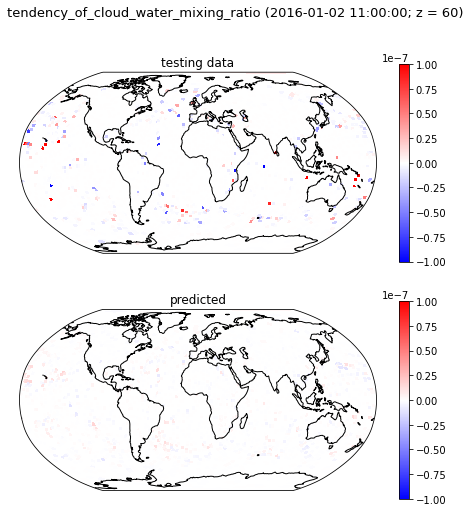

In [33]:
fig, axes = plt.subplots(2, 1, subplot_kw={"projection": ccrs.Robinson()}, figsize=(8, 8))
plt.suptitle('{v} ({t}; z = {z})'.format(v=dqcdt[:36], t=ds1.time.values, z=zlev), fontsize=13)

h1 = plot_cube_axes(
    ds1[dqcdt].values,
    ds1["lat"].values,
    ds1["lon"].values,
    ds1["latb"].values,
    ds1["lonb"].values,
    "pcolormesh",
    vmin=-1e-7,
    vmax=1e-7,
    cmap="bwr",
    ax=axes[0],
)
axes[0].set_title('testing data')
axes[0].coastlines()
plt.colorbar(h1, ax=axes[0], label="")

h2 = plot_cube_axes(
    ds2[dqcdt].values,
    ds2["lat"].values,
    ds2["lon"].values,
    ds2["latb"].values,
    ds2["lonb"].values,
    "pcolormesh",
    vmin=-1e-7,
    vmax=1e-7,
    cmap="bwr",
    ax=axes[1],
)
axes[1].set_title('predicted')
axes[1].coastlines()
plt.colorbar(h2, ax=axes[1], label="")
fig.set_size_inches([8, 8])

plt.savefig(SAVE_DIR + 'LR_tendency_t3_z60.png', dpi=300, bbox_inches='tight')

plt.show()


### Cloud water mixing ratio:

In [34]:
ds_qc_us = ds_qc.set_index(sample = ["tile", "x", "y", "time"]).transpose("sample", ...).unstack()
ds_qc_predict_us = ds_qc_predict.set_index(sample = ["tile", "x", "y", "time"]).transpose("sample", ...).unstack()


In [35]:
zlev_qc = int(ds_qc_us[qc].mean(dim=['x', 'y', 'tile', 'time']).argmax())

# RF predicted qc, calculated from predicted tendency & initial qc
ds3 = mappable_var(xr.merge([ds_qc_predict_us[qc].unstack().isel(z=zlev_qc).mean(dim='time'), grid_ds]), qc, 
                   **MAPPABLE_VAR_KWARGS).load()

# qc calculated from testing dataset (initial) qc and model output dqcdt
ds4 = mappable_var(xr.merge([ds_qc_us[qc].isel(z=zlev_qc).mean(dim='time'), grid_ds]), qc, 
                   **MAPPABLE_VAR_KWARGS).load()


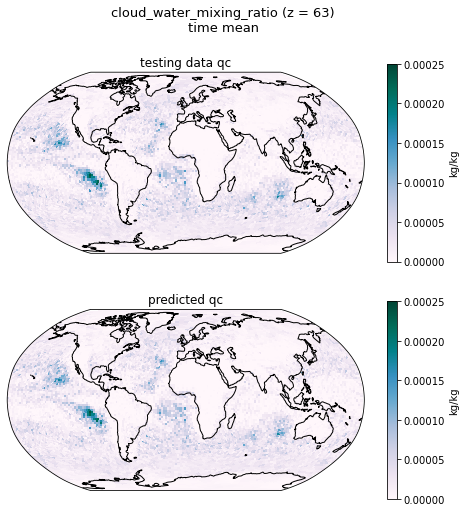

In [36]:
fig, axes = plt.subplots(2, 1, subplot_kw={"projection": ccrs.Robinson()}, figsize=(8, 8))
plt.suptitle('{v} (z = {z})\ntime mean'.format(v=qc, z=zlev_qc), fontsize=13)

h2 = plot_cube_axes(
    ds4[qc].values,
    ds4["lat"].values,
    ds4["lon"].values,
    ds4["latb"].values,
    ds4["lonb"].values,
    "pcolormesh",
    vmin=0,
    vmax=2.5e-4,
    cmap="PuBuGn",
    ax=axes[0],
)
axes[0].set_title('testing data qc')
axes[0].coastlines()
plt.colorbar(h2, ax=axes[0], label="kg/kg")

h1 = plot_cube_axes(
    ds3[qc].values,
    ds3["lat"].values,
    ds3["lon"].values,
    ds3["latb"].values,
    ds3["lonb"].values,
    "pcolormesh",
    vmin=0,
    vmax=2.5e-4,
    cmap="PuBuGn",
    ax=axes[1],
)
axes[1].set_title('predicted qc', )
axes[1].coastlines()
plt.colorbar(h1, ax=axes[1], label="kg/kg")

plt.savefig(SAVE_DIR + 'LR_time_mean_qc_z63.png', dpi=300, bbox_inches='tight')

plt.show()
